## Import lib

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import zscore, spearmanr
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from  statsmodels.stats import multitest
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from math import pi
import networkx as nx
import rcca
import matplotlib.cm as cm
import matplotlib as mpl

In [22]:
import nxviz as nv
from nxviz import utils

In [2]:
from nxviz.plots import CircosPlot

C:\Users\aemij\anaconda3\lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


## Find optimal parameter

In [ ]:
# CCA
import rcca

# X = zscore(asd_IG_sig, axis=1)
X = zscore(asd_IG, axis=1)
Y = ados
fold_k = 5

# identify optimal number of components and regularization parameter using all data
# !! REPEAT multiple times & select the most frequently observed result
# !! Empirically, ncomp >= 3, reg = 0.001 showed reasonable (best?) results
cca_cv = rcca.CCACrossValidate(kernelcca=True,ktype='linear',
    regs=[1e-4,1e-3,1e-2,1e-1],
    numCCs=range(1,11),
    numCV=fold_k, select=0.2)
cca_cv.train([X, Y])
ncomp = cca_cv.best_numCC
reg = cca_cv.best_reg


## Evaluate correlation & variance

In [ ]:
cca_corr = np.zeros([fold_k, ncomp])
cca_testcorr = [np.zeros([fold_k, np.shape(X)[1]]),
                np.zeros([fold_k, np.shape(Y)[1]])]
cca_ev = [np.zeros([fold_k, ncomp, np.shape(X)[1]]),
          np.zeros([fold_k, ncomp, np.shape(Y)[1]])]
cca_ws = [np.zeros([fold_k, np.shape(X)[1], ncomp]),
          np.zeros([fold_k, np.shape(Y)[1], ncomp])]
kf = KFold(n_splits=fold_k, shuffle=True, random_state=0)
for k, (train_index, test_index) in enumerate(kf.split(X)):
    print("k = " + str(k))

    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    cca = rcca.CCA(reg=reg, numCC=ncomp, verbose=False)
    cca.train([X_train, Y_train])
    cca.validate([X_test, Y_test])
    cca.compute_ev([X_test, Y_test])

    cca_corr[k,:] = cca.cancorrs
    cca_testcorr[0][k,:] = cca.corrs[0]     # test corr X
    cca_testcorr[1][k, :] = cca.corrs[1]
    cca_ev[0][k,:,:] = cca.ev[0]  # explained variance X
    cca_ev[1][k,:,:] = cca.ev[1]  #
    cca_ws[0][k,:,:] = cca.ws[0]  # canonical weights X
    cca_ws[1][k,:,:] = cca.ws[1]


## Correlation_spearman & FDR

In [ ]:
# correlation plot
rp_tot = np.zeros([fold_k, ncomp, 3])   # 3: rho/p/fdr
for k, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    CX = np.matmul(X_train, cca_ws[0][k, :, :])
    CY = np.matmul(Y_train, cca_ws[1][k, :, :])

    rp = np.zeros([ncomp,3])  # rho, p, fdr
    for nc in range(ncomp):
        [rho,p] = spearmanr(CX[:,nc],CY[:,nc])
        rp[nc,0] = rho
        rp[nc,1] = p
    rp[:,2] = multitest.fdrcorrection(rp[:,1])[1]
    rp_tot[k,:,:] = rp

# print("Mean/SD cca corr:")
# print(np.mean(cca_corr,axis=0))
# print(np.std(cca_corr,axis=0))
print("Mean/SD cca corr:")
print(np.mean(rp_tot,axis=0)[:,0])
print(np.std(rp_tot,axis=0)[:,0])
print("FDR:")
print(np.mean(rp_tot,axis=0)[:,2])
## we can report only significant component ##

# contribution
evX = np.mean(cca_ev[0], axis=0)
evY = np.mean(cca_ev[1], axis=0)


In [3]:
CX = np.load('C:/Users/aemij/Machine learning/figure3_npy_file/CX.npy')
CY = np.load("C:/Users/aemij/Machine learning/figure3_npy_file/CY.npy")
evX = np.load("C:/Users/aemij/Machine learning/figure3_npy_file/evX.npy")
evY = np.load("C:/Users/aemij/Machine learning/figure3_npy_file/evY.npy")

### 1st plot

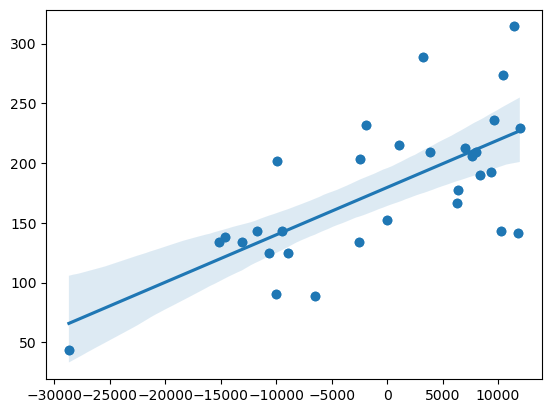

In [220]:
ax = plt.scatter(x=CX[:,0], y=CY[:,0])
#plt.title("1st component")
#plt.xlabel("Canonical X")
#plt.ylabel("Canonical Y")
sns.regplot(x=CX[:,0], y=CY[:,0])
#ax.get_xaxis().set_visible(False)
plt.show()

### 2nd plot

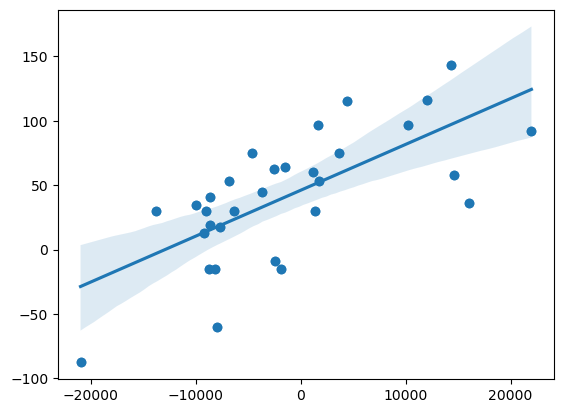

In [221]:
plt.scatter(x=CX[:,1], y=CY[:,1])
#plt.title("2nd component")
#plt.xlabel("Canonical X")
#plt.ylabel("Canonical Y")
sns.regplot(x=CX[:,1], y=CY[:,1])
plt.show()

### 3rd plot

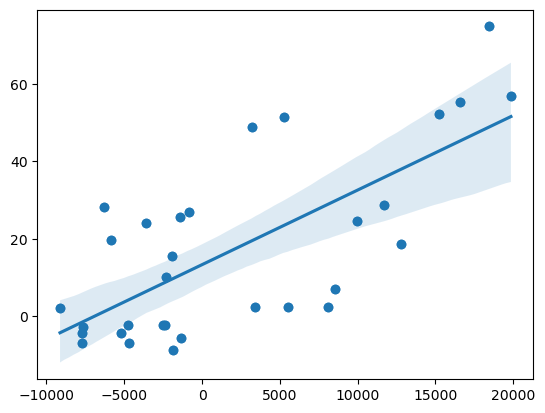

In [222]:
plt.scatter(x=CX[:,2], y=CY[:,2])
#plt.title("3rd component")
#plt.xlabel("Canonical X")
#plt.ylabel("Canonical Y")
sns.regplot(x=CX[:,2], y=CY[:,2])
plt.show()

## explained variance

In [9]:
# contribution
#evX = np.mean(cca_ev[0], axis=0)
#evY = np.mean(cca_ev[1], axis=0)

### ADOS

#### ADOS_1st comp

In [178]:
#color 설정
cmap = cm.RdBu_r

## 2단계 최대값과 최소값 결정
vmax = 1.2
vmin = 0
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

## 컬러바 생성
colormapping = cm.ScalarMappable(norm=norm, cmap=cmap)

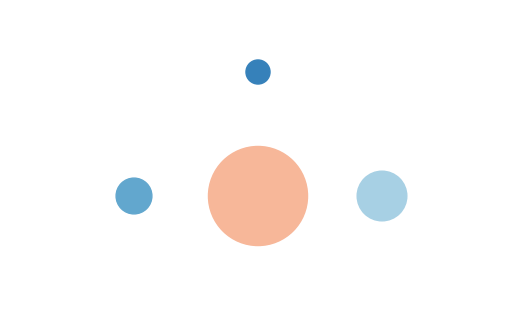

In [186]:

#plot 생성
circle_center_t = (0, 1) # 원의 중심
circle_center_s = (-2, -1)
circle_center_c = (0, -1)
circle_center_r = (2, -1)

circle_radius_t = evY[0][0]    # 원의 반지름
circle_radius_s = evY[0][1]
circle_radius_c = evY[0][2]
circle_radius_r = evY[0][3]

# 원의 객체 c 생성 (색채우기: 흰색, 둘레: 파란색)
c_t = plt.Circle(circle_center_t, circle_radius_t, color=cmap(norm(circle_radius_t)))
c_s = plt.Circle(circle_center_s, circle_radius_s, color=cmap(norm(circle_radius_s)))
c_c = plt.Circle(circle_center_c, circle_radius_c, color=cmap(norm(circle_radius_c)))
c_r = plt.Circle(circle_center_r, circle_radius_r, color=cmap(norm(circle_radius_r)))

# 축 설정
a = plt.axes(xlim=(-4, 4), ylim=(-3, 2))
a.add_patch(c_t)         # 원의 객체 c를 패치
a.add_patch(c_s) 
a.add_patch(c_c) 
a.add_patch(c_r) 

#cbar = plt.colorbar(colormapping, ax=plt.gca())
a.set_aspect('equal')  # X, Y축 1:1 비율로 설정
#plt.title("1st compoent_ADOS")
plt.axis('off')

plt.show() 

#### ADOS_2nd comp

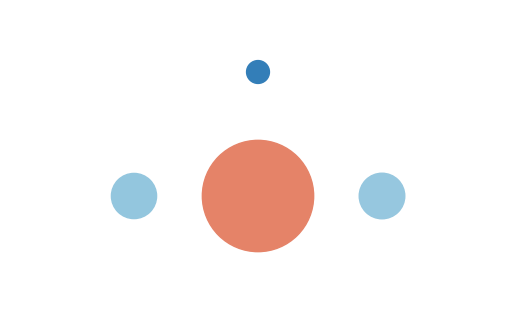

In [187]:
circle_center_t = (0, 1) # 원의 중심
circle_center_s = (-2, -1)
circle_center_c = (0, -1)
circle_center_r = (2, -1)

circle_radius_t = evY[1][0]    # 원의 반지름
circle_radius_s = evY[1][1]
circle_radius_c = evY[1][2]
circle_radius_r = evY[1][3]

# 원의 객체 c 생성 (색채우기: 흰색, 둘레: 파란색)
c_t = plt.Circle(circle_center_t, circle_radius_t, color=cmap(norm(circle_radius_t)))
c_s = plt.Circle(circle_center_s, circle_radius_s, color=cmap(norm(circle_radius_s)))
c_c = plt.Circle(circle_center_c, circle_radius_c, color=cmap(norm(circle_radius_c)))
c_r = plt.Circle(circle_center_r, circle_radius_r, color=cmap(norm(circle_radius_r)))

# 축 설정
a = plt.axes(xlim=(-4, 4), ylim=(-3, 2))
a.add_patch(c_t)         # 원의 객체 c를 패치
a.add_patch(c_s) 
a.add_patch(c_c) 
a.add_patch(c_r) 

#cbar = plt.colorbar(colormapping, ax=plt.gca())
a.set_aspect('equal')  # X, Y축 1:1 비율로 설정
#plt.title("2nd compoent_ADOS")
plt.axis('off')

plt.show() 

#### ADOS_3rd comp

In [181]:
evY[2]

array([0.18050262, 0.65188811, 0.63895662, 0.42743584])

In [ ]:
circle_center_t = (0, 1) # 원의 중심
circle_center_s = (-2, -1)
circle_center_c = (0, -1)
circle_center_r = (2, -1)

circle_radius_t = evY[2][0]    # 원의 반지름
circle_radius_s = evY[2][1]
circle_radius_c = evY[2][2]
circle_radius_r = evY[2][3]

# 원의 객체 c 생성 (색채우기: 흰색, 둘레: 파란색)
c_t = plt.Circle(circle_center_t, circle_radius_t, color=cmap(norm(circle_radius_t)))
c_s = plt.Circle(circle_center_s, circle_radius_s, color=cmap(norm(circle_radius_s)))
c_c = plt.Circle(circle_center_c, circle_radius_c, color=cmap(norm(circle_radius_c)))
c_r = plt.Circle(circle_center_r, circle_radius_r, color=cmap(norm(circle_radius_r)))

# 축 설정
a = plt.axes(xlim=(-4, 4), ylim=(-3, 2))
a.add_patch(c_t)         # 원의 객체 c를 패치
a.add_patch(c_s) 
a.add_patch(c_c) 
a.add_patch(c_r) 

#cbar = plt.colorbar(colormapping, ax=plt.gca(),location='bottom')
a.set_aspect('equal')  # X, Y축 1:1 비율로 설정
#plt.title("3rd compoent_ADOS")
plt.axis('off')

plt.show() 

In [5]:
circle_radius_t = evY[2][0]    # 원의 반지름
circle_radius_s = evY[2][1]
circle_radius_c = evY[2][2]
circle_radius_r = evY[2][3]

In [6]:
print(circle_radius_t)
print(circle_radius_s)
print(circle_radius_c)
print(circle_radius_r)

0.18050261777253682
0.6518881065226896
0.6389566198310026
0.4274358374866023


(0.0, 1.0, 0.0, 1.0)

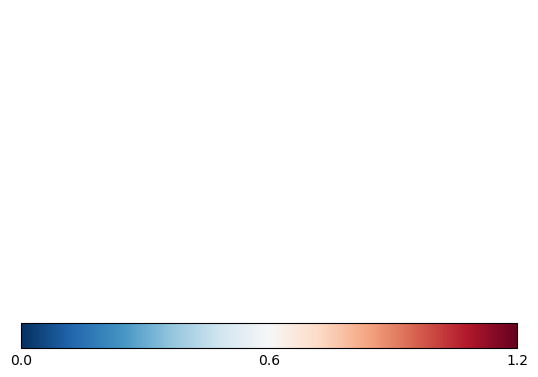

In [208]:
cbar = plt.colorbar(colormapping, ax=plt.gca(),location='bottom')
cbar.set_ticks([vmin, 0.5*(vmin+vmax), vmax]) ## 컬러바 눈금 좌표 설정
cbar.set_ticklabels(['0.0','0.6', '1.2'])
cbar.ax.tick_params(size=0)
plt.axis('off')

### 9900_spiderplot_within

#### matrix 변환

In [6]:
def making_matrix (fdr_matrix):
    fdr_200 = np.array(fdr_matrix)
    fdr_200_matrix = np.zeros((200, 200))
    matrix_200 = np.zeros((200, 200))
    for k in range(0, 100):
        if k == 99 or k == 199:
            fdr_200_matrix[k][k] = 0
        else:
            a = 4950 - ((99 - k) * (100 - k)) / 2
            a = int(a)
            change_matrix = fdr_200[a:a + (99 - k)]
            for n in range(0, 99):
                if n == 99 - (k):
                    break
                else:
                    fdr_200_matrix[k][k + n + 1] = change_matrix[n]
            for n in range(0, 99):
                if k == n:
                    fdr_200_matrix[k][k] = 0
    for k in range(100, 200):
        if k == 99 or k == 199:
            fdr_200_matrix[k][k] = 0
        else:
            a = 4950 * 2 - ((99 - (k - 100)) * (100 - (k - 100))) / 2
            a = int(a)
            change_matrix = fdr_200[a:a + (99 - (k - 100))]
            for n in range(0, 99):
                if n == 99 - (k - 100):
                    break
                else:
                    fdr_200_matrix[k][k + n + 1] = change_matrix[n]
            for n in range(100, 199):
                if k == n:
                    fdr_200_matrix[k][k] = 0
    matrix_200 = fdr_200_matrix.T + fdr_200_matrix
    return matrix_200

In [7]:
evX_200 = np.zeros([3,200,200])

for ncom in range(3):
    evX_200[ncom,:,:] = making_matrix(evX[ncom])

In [8]:
evX_200.shape

(3, 200, 200)

- schaefer200 7 networks label

In [9]:
label = []
label.append(np.arange(0,14))
label.append(np.arange(14,30))
label.append(np.arange(30,43))
label.append(np.arange(43,54))
label.append(np.arange(54,60))
label.append(np.arange(60,73))
label.append(np.arange(73,100))
label.append(np.arange(100,115))
label.append(np.arange(115,134))
label.append(np.arange(134,147))
label.append(np.arange(147,158))
label.append(np.arange(158,164))
label.append(np.arange(164,181))
label.append(np.arange(181,200))


In [10]:
Meanvalue= np.zeros([3,14,14])
mean = evX_200.copy()
for ncomp in range(evX_200.shape[0]):
    for row in range(0,14):
        for col in range(0,14):
            sumvalue = evX_200[ncomp][:,label[col]][label[row],:].mean()
            mean[ncomp][label[col][0]:label[col][-1]+1,label[row][0]:label[row][-1]+1] = sumvalue
            Meanvalue[ncomp][row][col]=sumvalue

In [3]:
Meanvalue = np.load("C:/Users/aemij/Machine learning/figure3_npy_file/Matrix.npy")

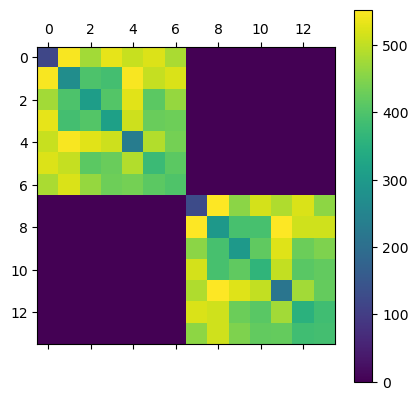

In [5]:
plt.matshow(Meanvalue[0])
plt.colorbar()

- dataframe 만들기

In [5]:
# Set data
df_w = pd.DataFrame({
'group': ['1st comp','2nd comp','3rd comp'],
'Visual': [(Meanvalue[k][0][0]+Meanvalue[k][7][7])/2 for k in range(3)],
'Somat': [(Meanvalue[k][1][1]+Meanvalue[k][8][8])/2 for k in range(3)],
'Dorsal': [(Meanvalue[k][2][2]+Meanvalue[k][9][9])/2 for k in range(3)],
'Ventral': [(Meanvalue[k][3][3]+Meanvalue[k][10][10])/2 for k in range(3)],
'Limbic': [(Meanvalue[k][4][4]+Meanvalue[k][11][11])/2 for k in range(3)],
'Fronto': [(Meanvalue[k][5][5]+Meanvalue[k][12][12])/2 for k in range(3)],
'Default': [(Meanvalue[k][6][6]+Meanvalue[k][13][13])/2 for k in range(3)]
})

In [6]:
df_w

,group,Visual,Somat,Dorsal,Ventral,Limbic,Fronto,Default
0,1st comp,122.833028,282.697923,303.844293,338.296819,224.284166,365.965641,393.363379
1,2nd comp,190.872807,441.226833,477.651726,541.921628,359.182272,570.966809,610.813004
2,3rd comp,140.309687,324.826776,348.880581,391.613873,260.233950,417.744481,449.584086


In [31]:
# number of variable
categories=list(df_w)[1:]
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
def spider_within(index): 
    values=df_w.loc[index].drop('group').values.flatten().tolist() # 1st component
    values += values[:1]
    values

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
    
    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories, color='grey', size=10)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0,350,700], color="grey", size=10)
    plt.ylim(0,700)

    # Plot data
    ax.plot(angles,np.abs(values), linewidth=2.3, linestyle='solid')
    #ax.tick_params(labelsize=0)
    # Fill area
    #ax.fill(angles,np.abs(values), 'b', alpha=0.1)

    # Show the graph
    plt.show()

#### 9900_within_plot 1st comp

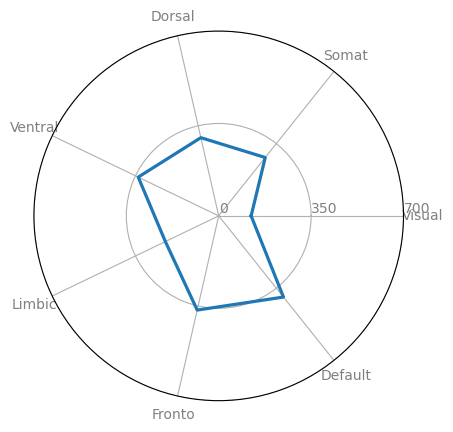

In [32]:
spider_within(0)

#### 9900_within_plot 2nd comp

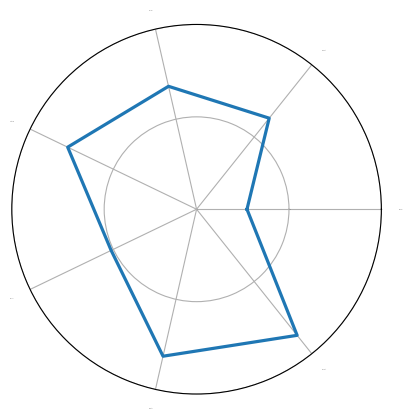

In [29]:
spider_within(1)

#### 9900_within_plot 3rd comp

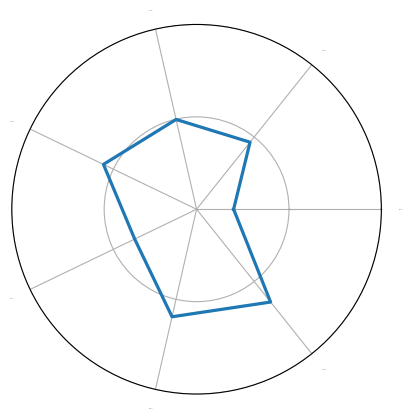

In [30]:
spider_within(2)

### 9900_spiderplot_between

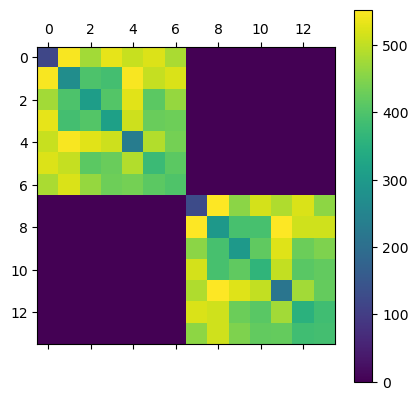

In [26]:
plt.matshow(Meanvalue[0])
plt.colorbar()

In [7]:
e_weight_mean = []
e_weight = []
for ncomp in range(3):
    for i in range(0,7):
        e_weight.append([(x+y)/2 for x,y in zip (Meanvalue[ncomp][0][i+1:7],Meanvalue[ncomp][i+7][i+8:14])])
    e_weight_mean.append(e_weight)
    e_weight = []

In [8]:
G_node = np.array(df_w.columns[1:])

G_1 = nx.Graph()
G_2 = nx.Graph()
G_3 = nx.Graph()

G_1.add_nodes_from(np.array([0,1,2,3,4,5,6]))
G_2.add_nodes_from(np.array([0,1,2,3,4,5,6]))
G_3.add_nodes_from(np.array([0,1,2,3,4,5,6]))

In [9]:
edges=[]
for i in range(0,6):
    for j in range(1+i,7):
        print((G_node[i],G_node[j]),e_weight_mean[0][i][j-(i+1)]/100.)

('Visual', 'Somat') 5.495649654191547
('Visual', 'Dorsal') 4.665279877257367
('Visual', 'Ventral') 5.24067070608396
('Visual', 'Limbic') 4.9711099534302265
('Visual', 'Fronto') 5.223180547157372
('Visual', 'Default') 4.702799501450085
('Somat', 'Dorsal') 4.3508013410567745
('Somat', 'Ventral') 4.619878541055978
('Somat', 'Limbic') 5.301829344277107
('Somat', 'Fronto') 5.179225518940841
('Somat', 'Default') 4.979449239822814
('Dorsal', 'Ventral') 4.742112609363383
('Dorsal', 'Limbic') 5.165391283338718
('Dorsal', 'Fronto') 4.763120267438662
('Dorsal', 'Default') 4.645383627625919
('Ventral', 'Limbic') 5.047692442106547
('Ventral', 'Fronto') 4.6777822159373725
('Ventral', 'Default') 4.5092989921617495
('Limbic', 'Fronto') 4.993390662938567
('Limbic', 'Default') 4.51870553483751
('Fronto', 'Default') 4.324420808894372


In [10]:
numnode = np.array([0,1,2,3,4,5,6])
for i in range(0,6):
    for j in range(i+1,7):
        G_1.add_edge(numnode[i],numnode[j],weight = e_weight_mean[0][i][j-(i+1)]/100.)     
        G_2.add_edge(numnode[i],numnode[j],weight = e_weight_mean[1][i][j-(i+1)]/100.)
        G_3.add_edge(numnode[i],numnode[j],weight = e_weight_mean[2][i][j-(i+1)]/100.)   

In [11]:
# Function to transform our list of brain areas into a dictionary
def Convert(lst): 
    res_dct = {i : lst[i] for i in range(0, len(lst))} 
    return res_dct
#linelist 지정
lineList = ['Visual', 'Somat', 'Dorsal', 'Ventral', 'Limbic', 'Fronto', 'Default']

# Obtaining a random list of numbers to simulate subnetworks -- THESE NUMBERS DO NOT CORRESPOND TO ANY REAL CLASSIFICATION
sublist = ['Visual', 'Somatomotor', 'Dorsal attention', 'Ventral attention', 'Limbic', 'Frontoparietal', 'Default mode']

# Obtaining a random list of colors that will match the random subnetwork classification for further graphs -- THESE COLORNAMES DO NOT CORRESPOND TO ANY REAL CLASSIFICATION
colorlist = ['purple','blue','green','violet','cream','orange','red']
color_hex = ['800080','0000FF','008000','EE82EE','FFFDD0','FFA500','FF0000']
colornumbs = np.array([1,2,3,4,5,6,7])

nodesize=np.array([1,1,1,1,1,1,1])

In [12]:
def set_node_attributes(G_sig):
    nx.set_node_attributes(G_sig, dict(G_sig.degree(weight='weight')), 'strength')
    nx.set_node_attributes(G_sig, Convert(lineList), 'area')
    nx.set_node_attributes(G_sig, Convert(colorlist), 'colorlist')
    nx.set_node_attributes(G_sig, Convert(color_hex), 'colorcode')
    nx.set_node_attributes(G_sig, Convert(sublist), 'subnet')
    # Add node color numbers
    nx.set_node_attributes(G_sig, Convert(colornumbs), 'colornumb')
    nx.set_node_attributes(G_sig, Convert(nodesize), 'nodesize')

In [13]:
set_node_attributes(G_1)
set_node_attributes(G_2)
set_node_attributes(G_3)

In [12]:
cmap=get_cmap(sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0,
                                     as_cmap=True))

### 1st comp circosplot

C:\Users\aemij\anaconda3\lib\site-packages\nxviz\utils.py:44: UserWarning: `infer_data_type` is deprecated! Please use `infer_data_family` instead!
  warnings.warn(


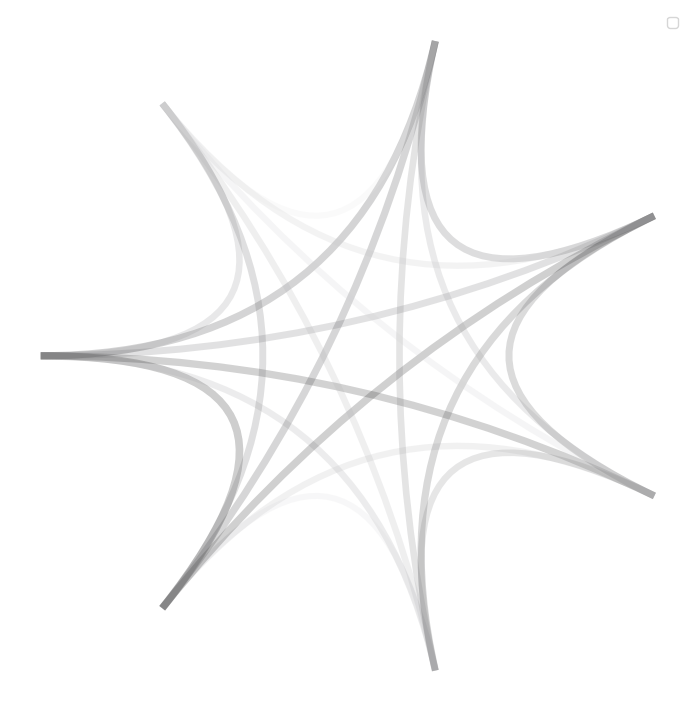

In [14]:
G_distance_dict2_sig = {(e1, e2): 1/abs(weight) for e1, e2, weight in G_1.edges(data='weight')}

# Then add them as attributes to the graph
nx.set_edge_attributes(G_1, G_distance_dict2_sig, 'distance')

st50GRL_sig = nx.relabel_nodes(G_1, {i: lineList[i] for i in range(len(lineList))})

# CircosPlot
circ = CircosPlot(G_1, figsize=(10,10), node_labels=False,
                   
                   edge_color='weight',edge_width='weight',node_label_layout='rotation' ,
                  node_color='colorlist', node_label_color=True, fontsize=20, 
                  nodeprops={"radius": 0.5}, group_legend=True, group_label_offset=5)

circ.draw()

circ.sm.colorbar.remove()
labels_networks = list(set([list(circ.graph.nodes.values())[n][circ.node_color] 
                                  for n in np.arange(len(circ.nodes))]))
labels_networks_ = [list(circ.graph.nodes.values())[n][circ.node_color] for n in np.arange(len(circ.nodes))]

#labels_networks.reverse()
#list(reversed(circ.legend_handles)

plt.legend(handles=circ.legend_handles,
   
           ncol=1,
           borderpad=1,
           shadow=True,
           fancybox=True,
           loc='best',
           fontsize=10,
           labels= sublist)
           
plt.legend('')
plt.show()

### 2st comp circosplot

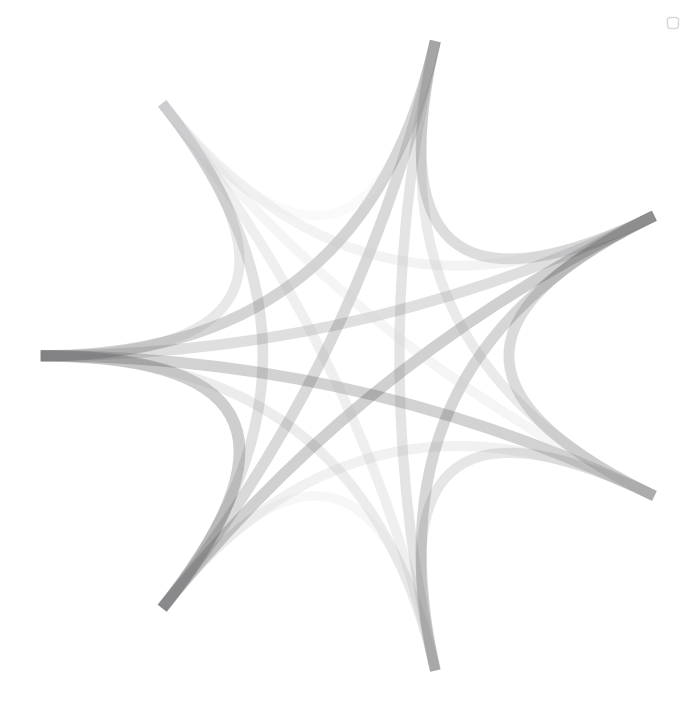

In [17]:
G_distance_dict2_sig = {(e1, e2): 1/abs(weight) for e1, e2, weight in G_2.edges(data='weight')}

# Then add them as attributes to the graph
nx.set_edge_attributes(G_2, G_distance_dict2_sig, 'distance')

st50GRL_sig = nx.relabel_nodes(G_2, {i: lineList[i] for i in range(len(lineList))})

# CircosPlot
circ = CircosPlot(G_2 , figsize=(10,10), node_labels=False,
                   
                   edge_color='weight',edge_width='weight',node_label_layout='rotation' ,
                  node_color='colorlist', node_label_color=True, fontsize=20, 
                  nodeprops={"radius": 0.5}, group_legend=True, group_label_offset=5)

circ.draw()

circ.sm.colorbar.remove()
labels_networks = list(set([list(circ.graph.nodes.values())[n][circ.node_color] 
                                  for n in np.arange(len(circ.nodes))]))
labels_networks_ = [list(circ.graph.nodes.values())[n][circ.node_color] for n in np.arange(len(circ.nodes))]

#labels_networks.reverse()
#list(reversed(circ.legend_handles)

plt.legend(handles=circ.legend_handles,
   
           ncol=1,
           borderpad=1,
           shadow=True,
           fancybox=True,
           loc='best',
           fontsize=10,
           labels= sublist)
           
plt.legend('')
plt.show()

### 3rd comp circosplot

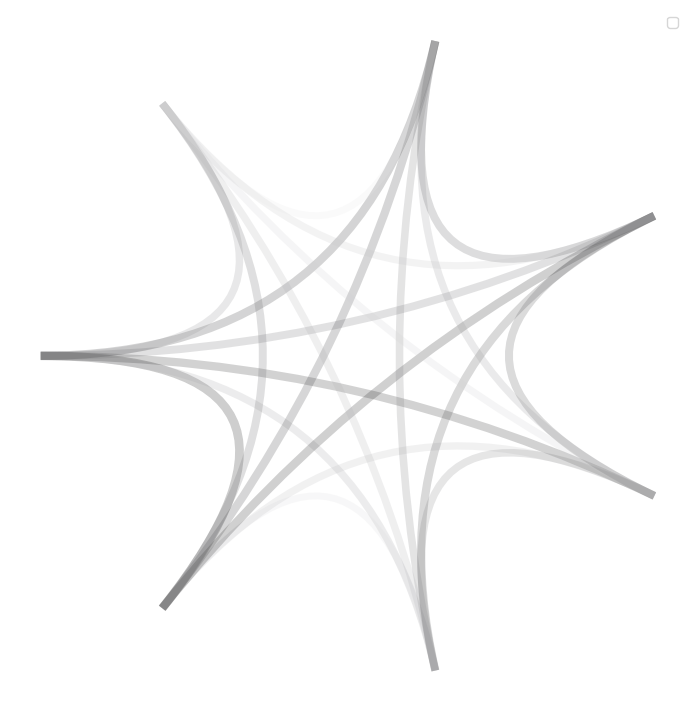

In [18]:
G_distance_dict2_sig = {(e1, e2): 1/abs(weight) for e1, e2, weight in G_3.edges(data='weight')}

# Then add them as attributes to the graph
nx.set_edge_attributes(G_3, G_distance_dict2_sig, 'distance')

st50GRL_sig = nx.relabel_nodes(G_3, {i: lineList[i] for i in range(len(lineList))})

# CircosPlot
circ = CircosPlot(G_3 , figsize=(10,10), node_labels=False,
                   
                   edge_color='weight',edge_width='weight',node_label_layout='rotation' ,
                  node_color='colorlist', node_label_color=True, fontsize=20, 
                  nodeprops={"radius": 0.5}, group_legend=True, group_label_offset=5)

circ.draw()

circ.sm.colorbar.remove()
labels_networks = list(set([list(circ.graph.nodes.values())[n][circ.node_color] 
                                  for n in np.arange(len(circ.nodes))]))
labels_networks_ = [list(circ.graph.nodes.values())[n][circ.node_color] for n in np.arange(len(circ.nodes))]

#labels_networks.reverse()
#list(reversed(circ.legend_handles)

plt.legend(handles=circ.legend_handles,
   
           ncol=1,
           borderpad=1,
           shadow=True,
           fancybox=True,
           loc='best',
           fontsize=10,
           labels= sublist)
           
plt.legend('')
plt.show()

In [ ]:
circ = nv.circos(st50GRL_sig,edge_alpha_by='weight',node_size_by='nodesize',
                  node_color_by='colorlist')
#annotate.circos_group(st50GRL_sig, group_by="area")
annotate.circos_labels(st50GRL_sig, group_by="area",radius= 0.05)
#annotate.node_colormapping(st50GRL_sig, color_by="colorlist")

#nodes.node_colors(utils.node_table(st50GRL_sig), color_by = "colorcode")
#edge_lw_by='weight'

#### 1st componet node/edge info

In [103]:
utils.edge_table(st50GRL_sig)

,weight,distance,source,target
0,5.495650,0.181962,Visual,Somat
1,5.495650,0.181962,Somat,Visual
2,4.665280,0.214349,Visual,Dorsal
3,4.665280,0.214349,Dorsal,Visual
4,5.240671,0.190815,Visual,Ventral
5,5.240671,0.190815,Ventral,Visual
6,4.971110,0.201162,Visual,Limbic
7,4.971110,0.201162,Limbic,Visual
8,5.223181,0.191454,Visual,Fronto
9,5.223181,0.191454,Fronto,Visual


#### 2nd componet node/edge info

In [210]:
utils.node_table(G_2)

,strength,area,colorlist,colorcode,subnet,colornumb,nodesize
0,4708.009342,Visual,purple,800080,Visual,1,0.5
1,4652.379809,Somat,blue,0000FF,Somatomotor,2,0.5
2,4412.367382,Dorsal,green,008000,Dorsal attention,3,0.5
3,4485.005411,Ventral,violet,EE82EE,Ventral attention,4,0.5
4,4673.963182,Limbic,cream,FFFDD0,Limbic,5,0.5
5,4535.640723,Fronto,orange,FFA500,Frontoparietal,6,0.5
6,4318.272688,Default,red,FF0000,Default mode,7,0.5


In [23]:
utils.edge_table(G_2)

,weight,distance,source,target
0,8.494531,0.117723,0,1
1,8.494531,0.117723,1,0
2,7.272145,0.137511,0,2
3,7.272145,0.137511,2,0
4,8.110338,0.123299,0,3
5,8.110338,0.123299,3,0
6,7.769081,0.128715,0,4
7,7.769081,0.128715,4,0
8,8.091090,0.123593,0,5
9,8.091090,0.123593,5,0


#### 3rd componet node/edge info

In [212]:
utils.node_table(G_3)

,strength,area,colorlist,colorcode,subnet,colornumb,nodesize
0,3455.091570,Visual,purple,800080,Visual,1,0.5
1,3416.736849,Somat,blue,0000FF,Somatomotor,2,0.5
2,3235.284960,Dorsal,green,008000,Dorsal attention,3,0.5
3,3291.267556,Ventral,violet,EE82EE,Ventral attention,4,0.5
4,3423.927182,Limbic,cream,FFFDD0,Limbic,5,0.5
5,3326.001826,Fronto,orange,FFA500,Frontoparietal,6,0.5
6,3160.876017,Default,red,FF0000,Default mode,7,0.5
